#libs

In [1]:
import os

HOME = os.getcwd()
print(HOME)

/content


In [2]:
!python --version

Python 3.10.12


In [ ]:
!pip install -U ultralytics
!pip install albumentations

In [85]:
from IPython import display

display.clear_output()

import ultralytics

ultralytics.checks()

import random

import albumentations as A
import cv2
import numpy as np
import yaml
from matplotlib import pyplot as plt
from tqdm import tqdm

Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 31.1/78.2 GB disk)


In [5]:
from IPython.display import Image, display
from ultralytics import YOLO

In [6]:
import locale


def getpreferredencoding(do_setlocale=True):
    return "UTF-8"


locale.getpreferredencoding = getpreferredencoding

#utils

In [64]:
def draw_yolo_bboxes(img, x, y, w, h, l):
    img_h, img_w, _ = img.shape
    x, y, w, h = x * img_w, y * img_h, w * img_w, h * img_h
    x1, y1, x2, y2 = int(x - w / 2), int(y - h / 2), int(x + w / 2), int(y + h / 2)
    cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
    cv2.putText(
        img,
        str(l),
        (x1 + x2 - x1, y1 + 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2,
        cv2.LINE_AA,
    )

In [62]:
def plot_images(image_paths, add_labels=True):
    num_images = len(image_paths)
    grid_size = int(np.ceil(np.sqrt(num_images)))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(16, 7))

    for i, path in enumerate(image_paths):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if add_labels:
            with open(
                path.replace("/images/", "/labels/").replace(".jpg", ".txt")
            ) as f:
                bboxes = [list(map(float, line.split())) for line in f.readlines()]
            for l, x, y, w, h in bboxes:
                draw_yolo_bboxes(image, x, y, w, h, l)

        row = i // grid_size
        col = i % grid_size
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    for i in range(num_images, grid_size**2):
        axes.flatten()[i].axis("off")

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [72]:
def save_transformed_image(img_name, transform, number):
    if not img_name.endswith(".jpg"):
        return
    image = cv2.imread(f"./datasets/train/images/{img_name}")
    with open(f"./datasets/train/labels/{img_name[:-4]}.txt") as f:
        data = f.read()
        bboxes = []
        for bbs in data.split("\n"):
            new = [
                float(val) if i != 0 else int(val) for i, val in enumerate(bbs.split())
            ]
            new.append(new[0])
            bboxes.append(new[1:])

    transformed = transform(image=image.copy(), bboxes=bboxes)
    transformed_image = transformed["image"]
    transformed_bboxes = transformed["bboxes"]

    cv2.imwrite(
        f"./datasets/train/images/{img_name[:-4]}-augmented-{number}.jpg",
        transformed_image,
    )
    final_data = ""
    for bbs in transformed_bboxes:
        bbs = list(map(str, bbs))
        final_data += f'{bbs[-1]} {" ".join(bbs[:-1])}\n'

    with open(
        f"./datasets/train/labels/{img_name[:-4]}-augmented-{number}.txt", "w"
    ) as f:
        f.write(final_data)

In [96]:
def get_bread_label(path):
    with open(path.replace("/images/", "/labels/").replace(".jpg", ".txt")) as f:
        bboxes = [list(map(float, line.split())) for line in f.readlines()]
    if len(bboxes) > 1:
        return LABELS[int(bboxes[1][0])]
    else:
        return LABELS[-1]

# dataset

Скачиваем датасет с google drive

In [9]:
!gdown 1O4IRU8LL8g_06k9iHq4PlE7z1fZOTeP1

Downloading...
From (original): https://drive.google.com/uc?id=1O4IRU8LL8g_06k9iHq4PlE7z1fZOTeP1
From (redirected): https://drive.google.com/uc?id=1O4IRU8LL8g_06k9iHq4PlE7z1fZOTeP1&confirm=t&uuid=843a2001-753e-43d1-9335-11a19f439b36
To: /content/bread_dataset_final.zip
100% 285M/285M [00:03<00:00, 85.1MB/s]


In [76]:
!zip -d "bread_dataset_final.zip" __MACOSX/\*
!unzip -q 'bread_dataset_final.zip' -d 'datasets'
!cp -r ./datasets/bread_dataset_final/. ./datasets/
!rm -rf ./datasets/bread_dataset_final

	zip warning: name not matched: __MACOSX/*

zip error: Nothing to do! (bread_dataset_final.zip)


In [86]:
with open("./datasets/data.yaml", "r") as file:
    LABELS = yaml.safe_load(file)["names"]

In [30]:
train_images = [
    os.path.join("./datasets/train/images", file)
    for file in os.listdir("./datasets/train/images")
]
val_images = [
    os.path.join("./datasets/valid/images", file)
    for file in os.listdir("./datasets/valid/images")
]

Рассмотрим тренировочную и валидационную выборку

Они должны содержать изображения батонов в разном положении в лотке, а также быть  представлены в разном количестве

Тренировочная:

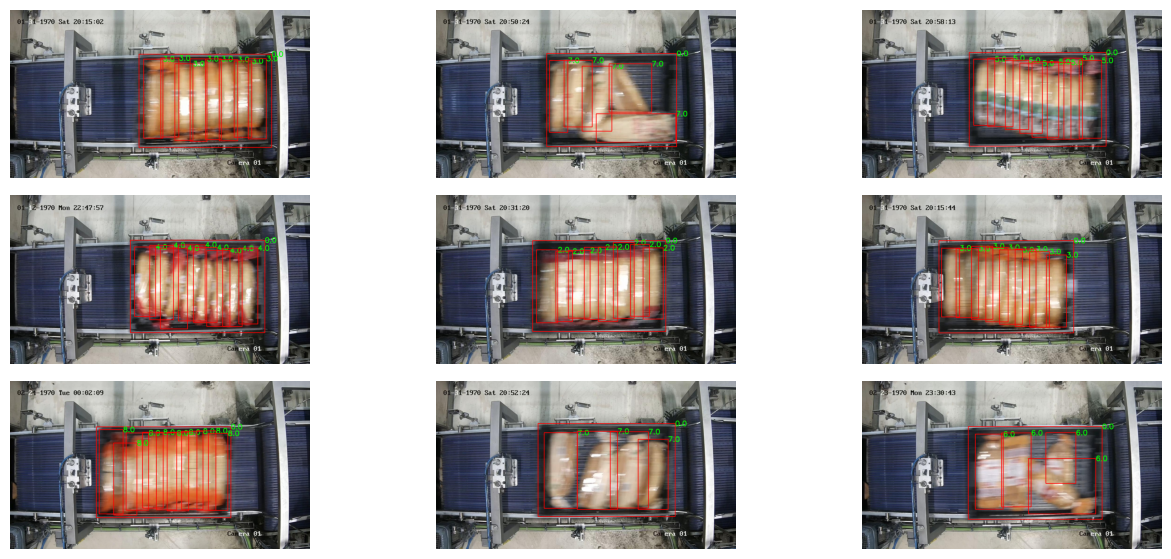

In [ ]:
np.random.seed(17)
plot_images(np.random.choice(train_images, 9))

Валидационная:

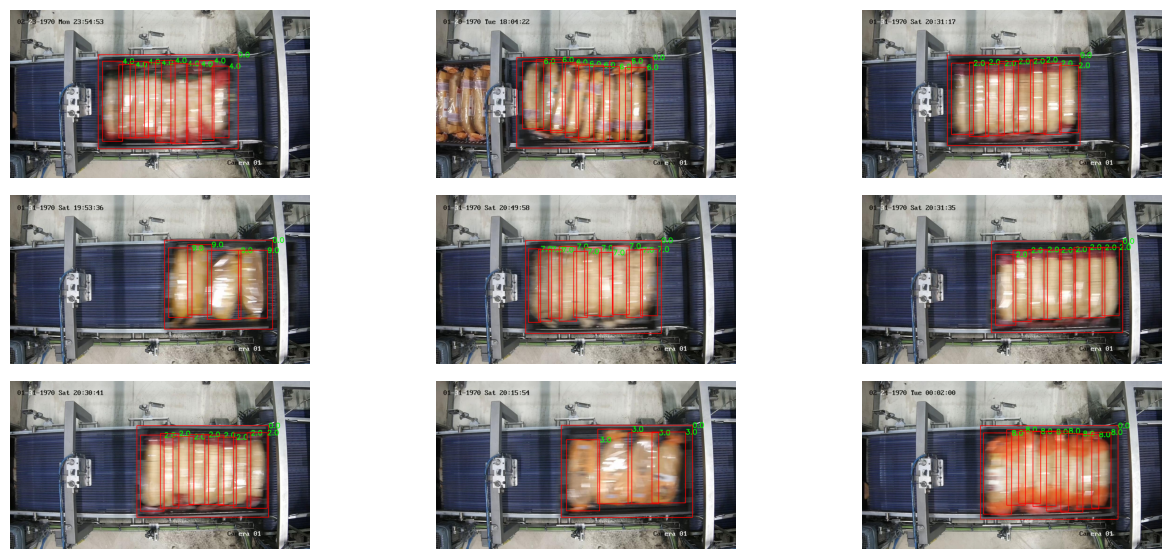

In [67]:
np.random.seed(17)
plot_images(np.random.choice(val_images, 9))

In [101]:
train_labels, train_counts = np.unique(
    [get_bread_label(path) for path in train_images], return_counts=True
)
val_labels, val_counts = np.unique(
    [get_bread_label(path) for path in val_images], return_counts=True
)

Рассмотрим распределение классов в выборках

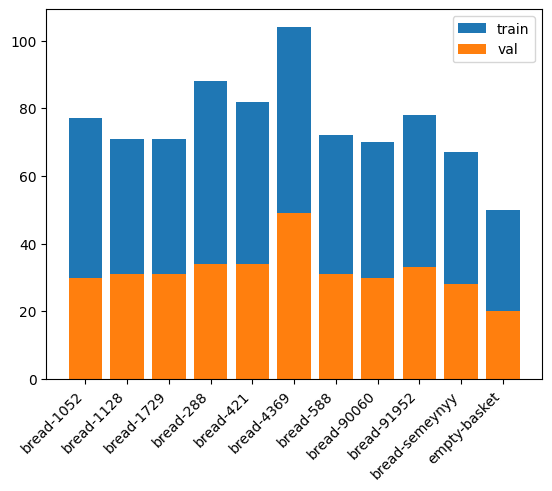

In [108]:
plt.bar(train_labels, train_counts, label="train")
plt.bar(val_labels, val_counts, label="val")
plt.xticks(rotation=45, ha="right")
plt.xlabel = "labels"
plt.ylabel = "amount"
plt.legend()
plt.show()

Классы достаточно сбалансированы, значит можно приступать к следующему шагу

# albumentations

К сожалению данного датасета недостаточно для хорошего качества модели, поэтому следует увеличить его посредством аугментации. (Забегая вперед, это улучшило метрики с 0.75 до 0.85 в среднем для классов продукции)

In [68]:
albums = [
    A.RandomCrop(width=1000, height=700, p=1),
    A.HorizontalFlip(p=1),
    A.RandomBrightnessContrast(p=1),
    A.PixelDropout(dropout_prob=0.05, per_channel=True, p=1),
    A.Superpixels(p_replace=0.05, max_size=512, interpolation=cv2.INTER_CUBIC, p=1),
    A.Posterize(num_bits=3, p=1),
    A.RandomGravel(number_of_patches=10, p=1),
    A.Sharpen(p=1),
    A.Cutout(num_holes=25, max_h_size=32, max_w_size=40, p=1),
    A.ZoomBlur(max_factor=1.1, p=1),
]
names = [
    "RandomCrop",
    "HorizontalFlip",
    "RandomBrightnessContrast",
    "PixelDropout",
    "Superpixels",
    "Posterize",
    "RandomGravel",
    "Sharpen",
    "Cutout",
    "ZoomBlur",
]
transform = A.Compose(albums, bbox_params=A.BboxParams(format="yolo"))

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Рассмотрим виды аугментации. Они были выбраны итерационным путем применяя тот или иной тип и сравнивая полученные метрики.

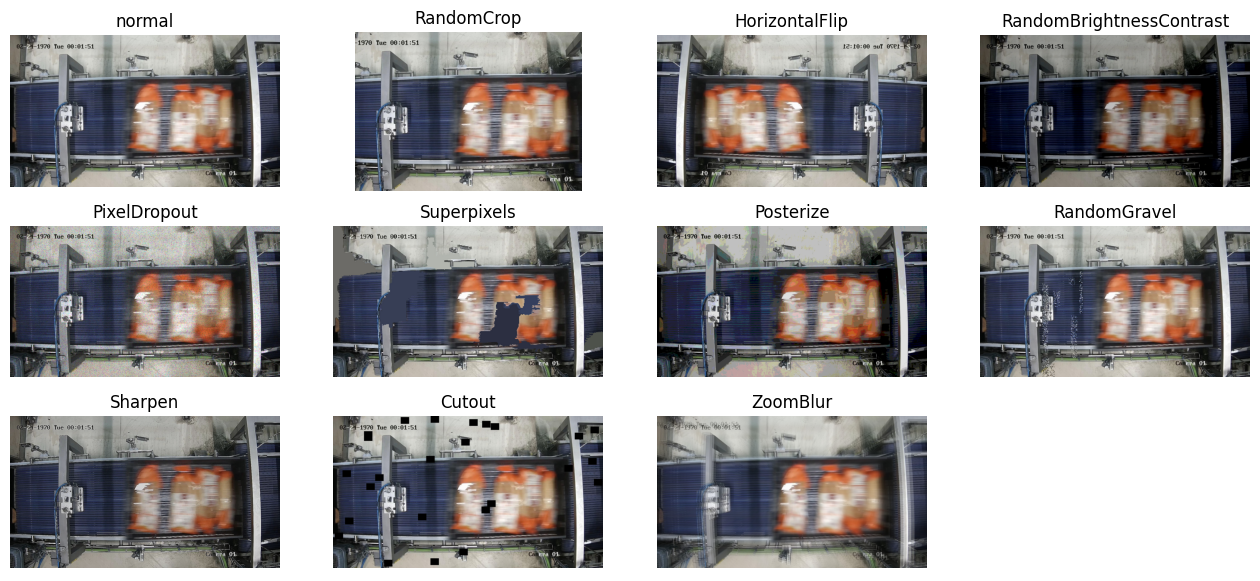

In [71]:
fig, axes = plt.subplots(3, 4, figsize=(16, 7))
img = cv2.imread(train_images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
axes[0, 0].imshow(img)
axes[0, 0].set_title("normal")
axes[0, 0].axis("off")
axes[-1, -1].axis("off")

for i, alb in enumerate(albums):
    img_new = img.copy()
    transform = A.Compose([alb], bbox_params=A.BboxParams(format="yolo"))
    axes[(i + 1) // 4, (i + 1) % 4].imshow(
        transform(image=img.copy(), bboxes=[])["image"]
    )
    axes[(i + 1) // 4, (i + 1) % 4].set_title(names[i])
    axes[(i + 1) // 4, (i + 1) % 4].axis("off")

In [77]:
for img_name in tqdm(os.listdir("./datasets/train/images/")):
    for i in range(3):
        save_transformed_image(img_name, transform, i)

100%|██████████| 830/830 [02:11<00:00,  6.33it/s]


## Custom Training

In [ ]:
import torch

torch.cuda.is_available()

True

In [ ]:
model = YOLO("yolov8s.pt")
results = model.train(data="datasets/data.yaml", epochs=50, imgsz=800)

100%|██████████| 21.5M/21.5M [00:00<00:00, 171MB/s]


Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=50, patience=50, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fal

100%|██████████| 755k/755k [00:00<00:00, 14.3MB/s]


Overriding model.yaml nc=80 with nc=12

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 6.23M/6.23M [00:00<00:00, 76.3MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/train/labels... 2490 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2490/2490 [00:01<00:00, 2083.09it/s]


train: New cache created: /content/datasets/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/valid/labels... 351 images, 0 backgrounds, 0 corrupt: 100%|██████████| 351/351 [00:00<00:00, 1275.08it/s]


val: New cache created: /content/datasets/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.05G      1.143      1.718      1.307        140        800: 100%|██████████| 156/156 [01:55<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.25it/s]

                   all        351       2694      0.906      0.838      0.911      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.15G     0.9072     0.6903      1.099        180        800: 100%|██████████| 156/156 [01:50<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]

                   all        351       2694       0.94      0.941      0.985      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.17G     0.8883     0.5863      1.079        168        800: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.44it/s]

                   all        351       2694      0.972       0.98      0.988      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.17G     0.8592     0.5281      1.055        177        800: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.94it/s]

                   all        351       2694      0.922      0.888      0.914      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.18G     0.8438     0.5135      1.056        160        800: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.38it/s]

                   all        351       2694      0.976      0.964      0.988      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         6G     0.8272     0.4865      1.038        150        800: 100%|██████████| 156/156 [01:48<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.76it/s]

                   all        351       2694      0.946      0.958      0.977      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.04G     0.8109     0.4686      1.029        139        800: 100%|██████████| 156/156 [01:51<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.42it/s]

                   all        351       2694      0.955      0.965      0.956       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.01G     0.8027     0.4459      1.028        175        800: 100%|██████████| 156/156 [01:50<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.38it/s]

                   all        351       2694      0.984      0.988       0.99      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.03G     0.7897     0.4213      1.019        201        800: 100%|██████████| 156/156 [01:51<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.65it/s]

                   all        351       2694      0.991      0.993      0.993      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.03G     0.7809     0.4139      1.012        140        800: 100%|██████████| 156/156 [01:50<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.81it/s]

                   all        351       2694      0.985      0.992      0.986      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.03G     0.7715     0.4018      1.012        156        800: 100%|██████████| 156/156 [01:48<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.42it/s]

                   all        351       2694      0.987      0.991       0.99      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.01G     0.7595        0.4      1.002        169        800: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.87it/s]

                   all        351       2694      0.987      0.994      0.991      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.03G      0.752     0.3927     0.9974        146        800: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.67it/s]

                   all        351       2694      0.969      0.989       0.99      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.01G     0.7397     0.3754     0.9953        137        800: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.64it/s]

                   all        351       2694      0.986      0.994      0.992      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.99G     0.7346     0.3731     0.9911        177        800: 100%|██████████| 156/156 [01:47<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]

                   all        351       2694      0.984      0.981      0.984      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.01G     0.7268      0.371     0.9865        132        800: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.45it/s]

                   all        351       2694      0.993      0.998      0.993       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.03G     0.7236     0.3648     0.9822        118        800: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.76it/s]

                   all        351       2694      0.994      0.998      0.993      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.04G     0.7103     0.3516     0.9752        167        800: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.41it/s]

                   all        351       2694       0.99      0.995      0.991      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.18G      0.709     0.3476     0.9777        175        800: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]

                   all        351       2694      0.988      0.994      0.991      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.18G     0.6972     0.3489     0.9689        170        800: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.41it/s]

                   all        351       2694       0.99      0.993       0.99      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.03G     0.6925     0.3444      0.968        169        800: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.77it/s]

                   all        351       2694      0.991      0.997      0.992      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.98G     0.6874     0.3454     0.9686        202        800: 100%|██████████| 156/156 [01:47<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.66it/s]

                   all        351       2694      0.993      0.998      0.993      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.03G     0.6771     0.3306     0.9641        139        800: 100%|██████████| 156/156 [01:45<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]

                   all        351       2694       0.99      0.996      0.992      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         6G     0.6704     0.3279     0.9572        176        800: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.40it/s]

                   all        351       2694       0.99      0.994       0.99      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         6G     0.6651      0.323     0.9558        183        800: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.80it/s]

                   all        351       2694      0.992      0.996      0.992      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.04G     0.6565     0.3215     0.9546        144        800: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.49it/s]

                   all        351       2694       0.99      0.995      0.992      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.03G     0.6498     0.3164     0.9491        138        800: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]

                   all        351       2694      0.994      0.998      0.993      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.03G     0.6443     0.3157     0.9482         83        800: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.78it/s]

                   all        351       2694      0.991      0.996      0.992       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.01G     0.6422     0.3121     0.9442         82        800: 100%|██████████| 156/156 [01:44<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.35it/s]

                   all        351       2694      0.992      0.997      0.993      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.98G     0.6399     0.3112     0.9444        140        800: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.91it/s]

                   all        351       2694      0.991      0.994      0.992      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.03G      0.626      0.303     0.9408        166        800: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.41it/s]

                   all        351       2694      0.988      0.997      0.993      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.04G     0.6216     0.3003     0.9376        168        800: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]

                   all        351       2694      0.989      0.993       0.99      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.99G     0.6171     0.2993     0.9344        196        800: 100%|██████████| 156/156 [01:47<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.51it/s]

                   all        351       2694      0.986      0.994       0.99       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.17G     0.6087     0.2935     0.9295        168        800: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.77it/s]

                   all        351       2694      0.989      0.994      0.987      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.99G      0.604     0.2936     0.9304        137        800: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.65it/s]

                   all        351       2694      0.988      0.993      0.991      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         6G     0.5995     0.2879     0.9264        173        800: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.44it/s]

                   all        351       2694      0.989      0.993      0.988      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.01G      0.589     0.2848     0.9259        183        800: 100%|██████████| 156/156 [01:47<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]

                   all        351       2694      0.988      0.993      0.991      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.02G     0.5788     0.2794     0.9205        182        800: 100%|██████████| 156/156 [01:47<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.54it/s]

                   all        351       2694      0.988      0.993      0.991      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.01G     0.5836     0.2799     0.9236        179        800: 100%|██████████| 156/156 [01:46<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]

                   all        351       2694       0.99      0.992      0.991      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.99G     0.5707     0.2732     0.9203        178        800: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]

                   all        351       2694      0.989      0.993      0.991      0.833


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.92G     0.5565      0.249     0.9243         84        800: 100%|██████████| 156/156 [01:46<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]

                   all        351       2694      0.989      0.994      0.989      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.92G     0.5388     0.2422     0.9146         83        800: 100%|██████████| 156/156 [01:42<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]

                   all        351       2694      0.988      0.992      0.985      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.94G     0.5299     0.2363     0.9137         79        800: 100%|██████████| 156/156 [01:40<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.04it/s]

                   all        351       2694      0.988      0.994      0.987      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.91G     0.5219     0.2338     0.9045         78        800: 100%|██████████| 156/156 [01:41<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]

                   all        351       2694      0.986      0.995      0.987       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.93G     0.5175     0.2325     0.9028         85        800: 100%|██████████| 156/156 [01:40<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]

                   all        351       2694      0.988      0.992      0.985       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.92G     0.5027      0.226     0.8959         79        800: 100%|██████████| 156/156 [01:41<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.97it/s]

                   all        351       2694      0.989      0.993      0.989       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.93G     0.5015     0.2255     0.8963         80        800: 100%|██████████| 156/156 [01:41<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]

                   all        351       2694      0.988      0.993      0.988      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.93G     0.4937     0.2215     0.8929         91        800: 100%|██████████| 156/156 [01:40<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.80it/s]

                   all        351       2694      0.989      0.992      0.987      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.92G     0.4873     0.2186      0.891         79        800: 100%|██████████| 156/156 [01:40<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]

                   all        351       2694      0.988      0.993      0.987       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.91G     0.4783     0.2157     0.8848         71        800: 100%|██████████| 156/156 [01:39<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        351       2694      0.989      0.991      0.986      0.829



50 epochs completed in 1.593 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11130228 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


                   all        351       2694      0.994      0.998      0.993      0.835
                basket        351        331          1          1      0.995      0.992
            bread-1052        351        218      0.999          1      0.995      0.809
            bread-1128        351        221      0.995          1      0.995      0.809
            bread-1729        351        201      0.995          1      0.995      0.817
             bread-288        351        262      0.999          1      0.995      0.805
             bread-421        351        229      0.991      0.996      0.992        0.8
            bread-4369        351        359      0.997      0.994      0.995      0.806
             bread-588        351        205      0.962      0.987      0.972      0.735
           bread-90060        351        200      0.999          1      0.995      0.816
           bread-91952        351        224      0.999          1      0.995      0.815
        bread-semeyny